# Image Processing

In [15]:
import os
import csv

# Image path
# image_folder = "/local/data1/honzh073/data/8bit_downsample"
image_folder = "/local/data1/honzh073/data/8bit_downsample"

# CSV path
csv_file_path = "/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/image_data.csv"

# Open the CSV file in write mode
with open(csv_file_path, 'w', newline='') as csvfile:
    # Define the CSV header fields
    fieldnames = ['HospitalID', 'PatientID', 'ImageID', 'ImagePath', 'Label']
    
    # Create a CSV writer object and write the header
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    # Iterate through files in the folder
    for filename in sorted(os.listdir(image_folder)):
        # Construct the complete image file path
        image_path = os.path.join(image_folder, filename)

        # Parse the filename to extract HospitalID, PatientID, image number, and image label
        parts = filename.split('_')
        hospital_id = parts[3]
        patient_id = parts[1]
        image_number = parts[6]
        image_label = parts[4]

        # Write data into the CSV file
        writer.writerow({
            'HospitalID': hospital_id,
            'PatientID': patient_id,
            'ImageID': image_number,
            'ImagePath': image_path,
            'Label': image_label
        })

# Print a message indicating that the CSV file has been created and saved
print("CSV file has been created and saved to:", csv_file_path)


CSV file has been created and saved to: /local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/image_data.csv


In [16]:
import csv
from collections import defaultdict
import random

# hospital ID
target_hospital_ids = ['43']

input_csv_path = "/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/image_data.csv"
patient_data = defaultdict(list)

with open(input_csv_path, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['HospitalID'] in target_hospital_ids:
            patient_id = row['PatientID']
            patient_data[patient_id].append(row)

num_patients = len(patient_data)

# ratio of train, val and test
num_train = int(num_patients * 0.6)
num_val = int(num_patients * 0.3)
num_test = num_patients - num_train - num_val

# patient ID
all_patient_ids = list(patient_data.keys())
random.seed(1) # set random seed to 1
random.shuffle(all_patient_ids)

train_patients = all_patient_ids[:num_train]
val_patients = all_patient_ids[num_train:num_train + num_val]
test_patients = all_patient_ids[num_train + num_val:]

train_data = []
val_data = []
test_data = []

for patient_id, images in patient_data.items():
    if patient_id in train_patients:
        train_data.extend(images)
    elif patient_id in val_patients:
        val_data.extend(images)
    elif patient_id in test_patients:
        test_data.extend(images)

def write_to_csv(file_path, data):
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=data[0].keys())
        writer.writeheader()
        writer.writerows(data)

write_to_csv('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/train.csv', train_data)
write_to_csv('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/val.csv', val_data)
write_to_csv('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/test.csv', test_data)

print("Saved train.csv, val.csv, and test.csv.")



Saved train.csv, val.csv, and test.csv.


In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import csv

def get_classweight(train_dataset):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # aff and nff numbers in training dataset
    train_nff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
    train_aff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF

    class_weight_nff = 1 / (2 * (train_nff_count / (train_nff_count + train_aff_count)))
    class_weight_aff = 1 / (2 * (train_aff_count / (train_nff_count + train_aff_count)))
    
    return [class_weight_nff, class_weight_aff]   
  
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = []
        self.transform = transform
        
        # 读取CSV文件
        with open(csv_file, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_path = row['ImagePath']
                label = row['Label']
                # 如果Label是‘NFF’，定义为0；如果label是‘AFF’，定义为1
                if label == 'NFF':
                    label = 1
                elif label == 'AFF':
                    label = 0
                else:
                    raise ValueError("Invalid label in CSV file.")
                self.data.append((image_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        # change to one channel image
        image = Image.open(image_path).convert('RGB')  # 'L' to gray image

        if self.transform:
            image = self.transform(image)

        return image, label

# Define data augmentation transforms for training data

# train_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=1),
#     transforms.RandomVerticalFlip(p=1),
#     transforms.RandomRotation(degrees=(0, 180)),
#     transforms.ColorJitter(brightness=0.5, contrast=0.1, saturation=0.1, hue=0.3),
#     # transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=1),
#     # transforms.GaussianBlur(kernel_size=(5,9), sigma=(0.1, 5)),
#     # transforms.RandomInvert(),
#     # transforms.RandomPosterize(bits=2),
#     transforms.RandomAdjustSharpness(sharpness_factor=4),
#     # transforms.RandomAutocontrast(),
#     # transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=1),
#     # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     transforms.Normalize(mean=[0.5], std=[0.5]),

# ])


train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=1),
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomAdjustSharpness(sharpness_factor=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 创建训练数据集
train_dataset = CustomDataset('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/train.csv', transform=train_transform)
val_dataset = CustomDataset('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/val.csv', transform=test_transform)
test_dataset = CustomDataset('/local/data1/honzh073/local_repo/FL/code/3_single_hospital/csv_files/test.csv', transform=test_transform)

repeated_dataset = torch.utils.data.ConcatDataset([train_dataset] * 30)

# 创建数据加载器
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# classweight
classweight = get_classweight(train_dataset)
print(classweight)
# device
# device = torch.device("cuda:0" if  torch.cuda.is_available() else "cpu")
AFF_label = 'AFF'
NFF_label = 'NFF'

train_AFF_count = sum(1 for row in train_data if row['Label'] == AFF_label)
train_NFF_count = sum(1 for row in train_data if row['Label'] == NFF_label)

val_AFF_count = sum(1 for row in val_data if row['Label'] == AFF_label)
val_NFF_count = sum(1 for row in val_data if row['Label'] == NFF_label)

test_AFF_count = sum(1 for row in test_data if row['Label'] == AFF_label)
test_NFF_count = sum(1 for row in test_data if row['Label'] == NFF_label)

print(f"train AFF: {train_AFF_count}, ratio: {train_AFF_count / (train_AFF_count + train_NFF_count):.2f}")
print(f"----- NFF: {train_NFF_count}, ratio: {train_NFF_count / (train_AFF_count + train_NFF_count):.2f}")
print('-----------------------------------')
print(f"val AFF: {val_AFF_count}, ratio: {val_AFF_count / (val_AFF_count + val_NFF_count):.2f}")
print(f"--- NFF: {val_NFF_count}, ratio: {val_NFF_count / (val_AFF_count + val_NFF_count):.2f}")
print('-----------------------------------')
print(f"test AFF: {test_AFF_count}, ratio: {test_AFF_count / (test_AFF_count + test_NFF_count):.2f}")
print(f"---- NFF: {test_NFF_count}, ratio: {test_NFF_count / (test_AFF_count + test_NFF_count):.2f}")


[1.4270833333333333, 0.7696629213483146]
train AFF: 48, ratio: 0.35
----- NFF: 89, ratio: 0.65
-----------------------------------
val AFF: 18, ratio: 0.25
--- NFF: 54, ratio: 0.75
-----------------------------------
test AFF: 9, ratio: 0.25
---- NFF: 27, ratio: 0.75


# Plot 8 bit Images

# Class weights of Training Dataset

# ResNet152
# 80% Training, 10% Validation, and 10% Test
# Test Performance

Epoch 1/50, Train Loss: 1.1334, Validation Loss: 1.4465, Train Acc: 54.01%, Validation Acc: 75.00%
Epoch 2/50, Train Loss: 2.0421, Validation Loss: 1.8486, Train Acc: 58.39%, Validation Acc: 73.61%
Epoch 3/50, Train Loss: 2.2224, Validation Loss: 2.3966, Train Acc: 54.74%, Validation Acc: 75.00%
Epoch 4/50, Train Loss: 2.0476, Validation Loss: 2.0163, Train Acc: 54.01%, Validation Acc: 75.00%
Epoch 5/50, Train Loss: 2.1095, Validation Loss: 2.1125, Train Acc: 56.20%, Validation Acc: 76.39%
Epoch 6/50, Train Loss: 1.9703, Validation Loss: 1.9705, Train Acc: 54.74%, Validation Acc: 73.61%
Epoch 7/50, Train Loss: 2.0511, Validation Loss: 2.1144, Train Acc: 58.39%, Validation Acc: 75.00%
Epoch 8/50, Train Loss: 2.1565, Validation Loss: 2.2782, Train Acc: 54.01%, Validation Acc: 75.00%
Epoch 9/50, Train Loss: 1.8705, Validation Loss: 2.0282, Train Acc: 65.69%, Validation Acc: 75.00%
Epoch 10/50, Train Loss: 2.0833, Validation Loss: 2.1865, Train Acc: 56.93%, Validation Acc: 75.00%
Epoch 11/

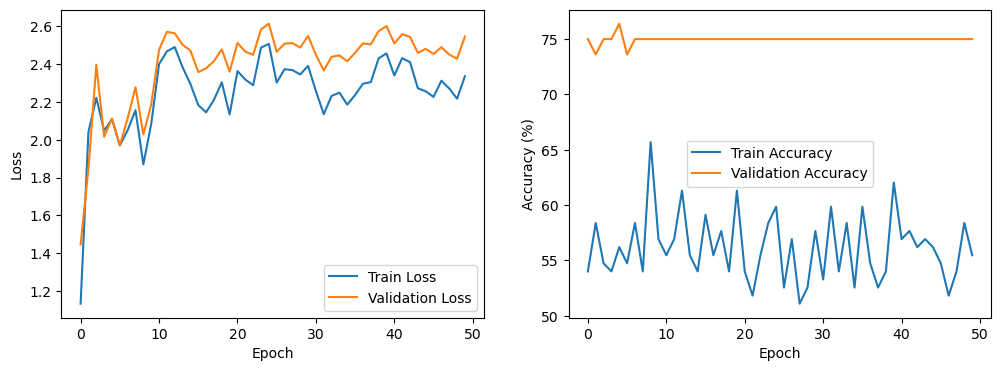

Test Loss: 2.7921, Test Acc: 75.00%


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# Settings
lr = 0.0001
step_size = 10
gamma = 0.1
device = torch.device("cuda:0" if  torch.cuda.is_available() else "cpu")

# # Class weights
# class_weights = [class_weight_aff, class_weight_nff]
class_weights = torch.Tensor(classweight).to(device)

# ResNet152
model = models.resnet152(pretrained=True)
# Modify the final fully connected (fc) layer to match the number of classes in your dataset
num_classes = 2  # Assuming 2 classes (you can adjust this)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Load trained model's weights
checkpoint = torch.load('/local/data1/honzh073/saved_model/fracatlas.pth')
model.load_state_dict(checkpoint)  # Load the model's state_dict directly

# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Training (loss and accuracy)
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    
    model.eval()
    correct_validation = 0
    total_validation = 0
    validation_loss = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)
            total_validation += labels.size(0)
            correct_validation += (predicted == labels).sum().item()
            validation_loss += loss.item()
    
    validation_accuracy = 100 * correct_validation / total_validation
    validation_loss /= len(val_loader)
    
    train_losses.append(loss.item())
    validation_losses.append(validation_loss)
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {validation_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Acc: {validation_accuracy:.2f}%")
    
    scheduler.step()  # Step the learning rate scheduler

# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Test dataset performance
model.eval()
correct_test = 0
total_test = 0
test_loss = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        test_loss += loss.item()

test_accuracy = 100 * correct_test / total_test
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")


In [21]:

# Test dataset performance
model.eval()
correct_test = 0
total_test = 0
test_loss = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        test_loss += loss.item()

test_accuracy = 100 * correct_test / total_test
test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

Test Loss: 2.7921, Test Acc: 75.00%


In [22]:
from sklearn.metrics import confusion_matrix, classification_report

# 获取原始数据集的类别标签
original_classes = test_loader.dataset.classes

# 计算混淆矩阵和分类报告
with torch.no_grad():
    all_predictions = []
    all_labels = []

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 生成混淆矩阵
conf_matrix = confusion_matrix(all_labels, all_predictions)

# 计算 Precision、Recall、F1 Score
classification_rep = classification_report(all_labels, all_predictions, target_names=original_classes)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)
# 85 AFF 350 NFF

AttributeError: 'CustomDataset' object has no attribute 'classes'

# Save model

In [ ]:
# Save the trained VGG model
# torch.save(model.state_dict(), 'transfer_patient_level_resnet152.pth')


# Clean GPU memory

In [ ]:
torch.cuda.empty_cache()


# VGG19